## Sediment-Type Analysis for *Zostera capricorni* (2010–2018)

This notebook examines whether different sediment types influence *Zostera capricorni* (ZC) occupancy across eight GBR sites.  
It builds a monthly sediment dataset (`sed_month`) from raw TropWATER surveys, merges it with ZC occupancy data (`occ_zc`), and fits a binomial Generalized Linear Model (GLM) using sediment category dummies as predictors.  
*Sand* serves as the baseline substrate for comparison.  
The workflow proceeds as follows:

1. **Helper functions:**  
   Define utilities to locate columns, parse month names, normalize sediment classes, infer ZC presence, and compute dominant sediment type per site×month.  
   These ensure robust handling of varying column names and missing values.

2. **Create monthly sediment panel (`sed_month`):**  
   If not already defined, extract sediment fields from the raw survey file.  
   Clean text labels into standard classes (*sand*, *muddy sand*, *mud/silt*, etc.) and generate dummy variables for GLM input.  
   Output is a tidy site×month sediment dataset with both categorical (`sediment`) and numeric (`mud_index`) indicators.

3. **Build ZC-only occupancy table (`occ_zc`):**  
   Detect *Z. capricorni* presence using species keywords and aggregate survey records by site and month to calculate `n` (samples), `k` (detections), and `p` (occupancy proportion).  
   This forms the model’s response variable.

4. **Merge and fit GLM:**  
   Join `sed_month` and `occ_zc` on site×month.  
   Fit a binomial GLM:  
   \[
   \text{logit}(p) = \beta_0 + \sum_i \beta_i \times \text{Sediment}_i
   \]
   where *sand* is the baseline category.  
   Model output includes coefficients, standard errors, and confidence intervals.

5. **Odds-ratio table:**  
   Exponentiate GLM coefficients to obtain odds ratios (OR) and 95 % confidence limits.  
   Display OR values showing how each sediment type’s likelihood of ZC presence compares with sand.

6. **Forest plot of sediment effects:**  
   Plot odds ratios on a log-scale with confidence intervals to visualize the direction and strength of sediment effects.  
   OR > 1 → higher occupancy than sand; OR < 1 → lower occupancy.

7. **Marginal predicted occupancy:**  
   Compute predicted ZC occupancy for each sediment category while holding other factors constant.  
   Plot predicted means ± CI to show relative differences among sediment types.

All figures are exported automatically:  
- `ZC_sediment_OR_forest.png` — odds-ratio forest plot  
- `ZC_sediment_marginal_effects.png` — marginal predicted occupancy

This analysis serves as an **additional exploratory test** complementing the main environmental and biotic driver models.


[built] sed_month: (112, 9)
[built] occ_zc: (112, 5)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  112
Model:                            GLM   Df Residuals:                      108
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19737.
Date:                Mon, 27 Oct 2025   Deviance:                       6279.8
Time:                        11:48:13   Pearson chi2:                 5.93e+03
No. Iterations:                     4   Pseudo R-squ. (CS):             0.5957
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

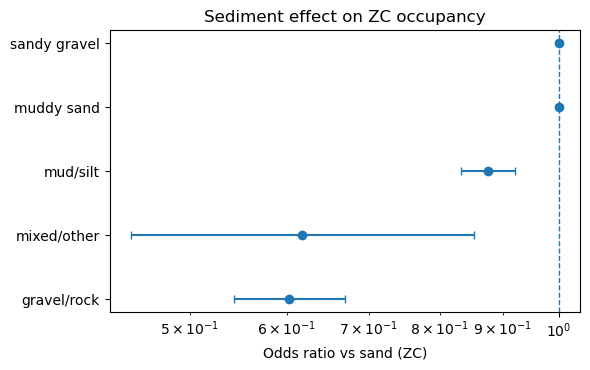

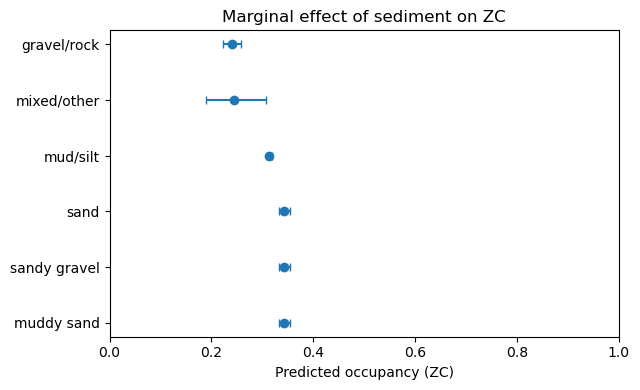

Saved: ZC_sediment_OR_forest.png, ZC_sediment_marginal_effects.png


In [1]:
# === One-cell fix: build sed_month if missing, then run ZC-only model ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

PATH_SURVEY = Path("GBR_NESP-TWQ-3.2.1-5.4_JCU_Seagrass_1984-2018_Site-surveys.csv")
YEAR_MIN, YEAR_MAX = 2010, 2018
TARGET_SPECIES_KEYWORDS = ["zostera","capricorni"]  # ZC only
SED_PREFIX = "sed_"  # dummy prefix; baseline will be 'sand'

# ---------- helpers ----------
def pick(df, name):
    up = name.upper()
    for c in df.columns:
        if c.upper()==up: return c
    for c in df.columns:
        if up in c.upper(): return c
    raise KeyError(f"column like '{name}' not found")

def to_month(x):
    if pd.isna(x): return pd.NA
    s = str(x).strip()
    if s.replace('.','',1).isdigit():
        try:
            v = int(float(s)); return v if 1<=v<=12 else pd.NA
        except: return pd.NA
    full = ["JANUARY","FEBRUARY","MARCH","APRIL","MAY","JUNE","JULY","AUGUST","SEPTEMBER","OCTOBER","NOVEMBER","DECEMBER"]
    abbr = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    lut = {m:i for i,m in enumerate(full,1)} | {m:i for i,m in enumerate(abbr,1)}
    return lut.get(s.upper(), pd.NA)

def ensure_ym_period(df, date_col=None):
    df = df.copy()
    if "ym" not in df.columns:
        if date_col is None: raise ValueError("Need 'ym' or a date column.")
        dt = pd.to_datetime(df[date_col], errors="coerce")
        df["ym"] = pd.PeriodIndex(dt.dt.to_period("M"))
    else:
        if not isinstance(df["ym"].dtype, pd.PeriodDtype):
            df["ym"] = pd.PeriodIndex(pd.to_datetime(df["ym"].astype(str)).to_period("M"))
    return df

def clean_sed(s):
    s = str(s).strip().lower().replace("&"," and ").replace("/", " ")
    if any(k in s for k in ["mud","silt","clay"]):
        return "muddy sand" if "sand" in s else "mud/silt"
    if "sand" in s:
        return "sandy gravel" if any(k in s for k in ["gravel","pebble"]) else "sand"
    if any(k in s for k in ["gravel","pebble","cobble","rubble","rock","reef"]): return "gravel/rock"
    if "seagrass" in s: return "sand"
    return "mixed/other"

def mode_str(x):
    cnt = x.value_counts()
    if cnt.empty: return np.nan
    top = cnt.index[cnt.values==cnt.max()].tolist()
    priority = {"mud/silt":3,"muddy sand":2,"sand":1,"sandy gravel":1,"gravel/rock":0,"mixed/other":1}
    top.sort(key=lambda k: priority.get(k,1), reverse=True)
    return top[0]

def infer_presence_from_sv(sv_df, keywords=TARGET_SPECIES_KEYWORDS):
    # presence-like column
    cand = [c for c in sv_df.columns if any(k in c.lower() for k in ["present","presence","pres","occurrence","found"])]
    if cand:
        s = sv_df[cand[0]].astype(str).str.lower()
        return s.isin(["1","true","yes","y","t"]) | s.str.contains("present|yes|true", na=False)
    # species/name column
    scols = [c for c in sv_df.columns if any(k in c.lower() for k in ["species","taxon","spp","name","genus","epithet","seagrass"])]
    if scols:
        s = sv_df[scols[0]].astype(str).str.lower()
        hit = s.notna()
        for kw in keywords: hit &= s.str.contains(kw, na=False)
        return hit.fillna(False)
    # cover-like column
    ccols = [c for c in sv_df.columns if any(k in c.lower() for k in ["cover","density","biomass","percent","%"])]
    if ccols:
        return pd.to_numeric(sv_df[ccols[0]], errors="coerce").fillna(0) > 0
    raise ValueError("Cannot infer ZC presence from survey columns.")

# ---------- ensure sed_month exists ----------
try:
    sed_month
except NameError:
    sv = pd.read_csv(PATH_SURVEY)
    sv.columns = [c.strip() for c in sv.columns]
    col_site, col_year, col_month, col_sed = pick(sv,"SURVEY_NAM"), pick(sv,"YEAR"), pick(sv,"MONTH"), pick(sv,"SEDIMENT")
    df_sed = sv[[col_site,col_year,col_month,col_sed]].copy()
    df_sed.columns = ["site","year","month_raw","sediment_raw"]
    df_sed["year"]  = pd.to_numeric(df_sed["year"], errors="coerce").astype("Int64")
    df_sed["month"] = df_sed["month_raw"].apply(to_month).astype("Int64")
    df_sed = df_sed.dropna(subset=["site","year","month","sediment_raw"])
    df_sed = df_sed[df_sed["year"].between(YEAR_MIN, YEAR_MAX, inclusive="both")].copy()
    dt = pd.to_datetime(df_sed["year"].astype(int).astype(str)+"-"+df_sed["month"].astype(int).astype(str)+"-01")
    df_sed["ym"] = pd.PeriodIndex(dt.dt.to_period("M"))
    df_sed["sediment"] = df_sed["sediment_raw"].apply(clean_sed)
    sed_month = (df_sed.groupby(["site","ym"], as_index=False)["sediment"].agg(mode_str))
    mud_map = {"mud/silt":2,"muddy sand":1,"sand":0,"sandy gravel":0,"gravel/rock":0,"mixed/other":1}
    sed_month["mud_index"] = sed_month["sediment"].map(mud_map).astype("Int64")
    order = ["sand","muddy sand","mud/silt","sandy gravel","gravel/rock","mixed/other"]
    sed_month["sediment"] = pd.Categorical(sed_month["sediment"], categories=order)
    dummies = pd.get_dummies(sed_month["sediment"], prefix=SED_PREFIX.rstrip("_"))
    if f"{SED_PREFIX}sand" in dummies.columns: dummies = dummies.drop(columns=[f"{SED_PREFIX}sand"])
    sed_month = pd.concat([sed_month, dummies], axis=1)
    print("[built] sed_month:", sed_month.shape)

# ---------- build ZC-only occ_zc if missing ----------
try:
    occ_zc
except NameError:
    if "sv" not in globals():
        sv = pd.read_csv(PATH_SURVEY); sv.columns = [c.strip() for c in sv.columns]
    col_site, col_year, col_month = pick(sv,"SURVEY_NAM"), pick(sv,"YEAR"), pick(sv,"MONTH")
    df = sv.copy()
    df["site"]  = df[col_site].astype(str)
    df["year"]  = pd.to_numeric(df[col_year], errors="coerce").astype("Int64")
    df["month"] = df[col_month].apply(to_month).astype("Int64")
    df = df.dropna(subset=["site","year","month"])
    df = df[df["year"].between(YEAR_MIN, YEAR_MAX, inclusive="both")]
    dt = pd.to_datetime(df["year"].astype(int).astype(str)+"-"+df["month"].astype(int).astype(str)+"-01", errors="coerce")
    df["ym"] = pd.PeriodIndex(dt.dt.to_period("M"))
    df["present"] = infer_presence_from_sv(df).astype(int)  # ZC presence
    occ_zc = (df.groupby(["site","ym"])
                .agg(n=("present","size"), k=("present","sum"))
                .assign(p=lambda d: d["k"]/d["n"])
                .reset_index())
    print("[built] occ_zc:", occ_zc.shape)

# ---------- merge & fit ZC-only model with sediment only ----------
sed_month = ensure_ym_period(sed_month)
occ_zc    = ensure_ym_period(occ_zc)

panel_zc = (sed_month
            .merge(occ_zc[["site","ym","k","n","p"]], on=["site","ym"], how="inner"))

sed_terms = [c for c in panel_zc.columns if c.startswith(SED_PREFIX)]
if not sed_terms:
    raise ValueError("No sediment dummies found. Check dummy prefix or build mud_index instead.")

dat = panel_zc.dropna(subset=sed_terms+["k","n"]).copy()
y = (dat["k"]/dat["n"]).values
X = sm.add_constant(dat[sed_terms].astype(float), has_constant="add")
glm_zc = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=dat["n"].values).fit()
print(glm_zc.summary())

# ---------- OR table ----------
ci = glm_zc.conf_int()
or_df = (pd.DataFrame({
    "term": glm_zc.params.index,
    "OR":   np.exp(glm_zc.params.values),
    "lo":   np.exp(ci[0].values),
    "hi":   np.exp(ci[1].values)
}).query("term!='const'"))
print("\n[ZC] Odds ratios vs 'sand':\n", or_df)

# ---------- plots ----------
# Forest
plot_or = or_df.replace([np.inf,-np.inf], np.nan).dropna().copy()
plot_or["label"] = plot_or["term"].str.replace("^"+SED_PREFIX, "", regex=True)
plot_or = plot_or.sort_values("OR")
fig, ax = plt.subplots(figsize=(6,3.8))
ypos = np.arange(len(plot_or))
ax.errorbar(plot_or["OR"], ypos, xerr=[plot_or["OR"]-plot_or["lo"], plot_or["hi"]-plot_or["OR"]], fmt="o", capsize=3)
ax.axvline(1.0, ls="--", lw=1); ax.set_xscale("log")
ax.set_yticks(ypos); ax.set_yticklabels(plot_or["label"])
ax.set_xlabel("Odds ratio vs sand (ZC)"); ax.set_title("Sediment effect on ZC occupancy")
plt.tight_layout(); plt.savefig("ZC_sediment_OR_forest.png", dpi=220); plt.show()

# Marginal predicted occupancy
labels = ["sand"] + [c.replace(SED_PREFIX,"") for c in sed_terms]
scenarios = [{**{c:0.0 for c in sed_terms}, "const":1.0}]  # sand baseline
for c in sed_terms:
    row = {k:0.0 for k in sed_terms}; row[c]=1.0; row["const"]=1.0; scenarios.append(row)
Xnew = pd.DataFrame(scenarios)[glm_zc.params.index]
sf = glm_zc.get_prediction(Xnew).summary_frame()
pm, plo, phi = sf["mean"].values, sf["mean_ci_lower"].values, sf["mean_ci_upper"].values
order = np.argsort(-pm); labels=[labels[i] for i in order]; pm,plo,phi = pm[order],plo[order],phi[order]
fig, ax = plt.subplots(figsize=(6.5,4))
ypos = np.arange(len(labels))
ax.errorbar(pm, ypos, xerr=[pm-plo, phi-pm], fmt="o", capsize=3)
ax.set_yticks(ypos); ax.set_yticklabels(labels)
ax.set_xlim(0,1); ax.set_xlabel("Predicted occupancy (ZC)")
ax.set_title("Marginal effect of sediment on ZC")
plt.tight_layout(); plt.savefig("ZC_sediment_marginal_effects.png", dpi=220); plt.show()

print("Saved: ZC_sediment_OR_forest.png, ZC_sediment_marginal_effects.png")